# Run Mask R-CNN on SBB compressed data and Raw data from TORCS

* Separately count the accuracy reduction of each of the 5 events
* Use Mask R-CNN results on highest quality images as Ground Truth

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

import glob

# %matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "SBB_NLP_example")

# # indicate GPUs
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_I

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

P2: Tensor("fpn_p2/BiasAdd:0", shape=(?, ?, ?, 256), dtype=float32)
P3: Tensor("fpn_p3/BiasAdd:0", shape=(?, ?, ?, 256), dtype=float32)
rpn_class_logits Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32)
pooled from pyramid ROI align:  (1, ?, 7, 7, 256)
shared features:  (?, 1000, 1024)
mrcnn_class:  (?, 1000, 81)
rpn_rois:  (1, ?, ?)
shared_features:  (?, 1000, 1024)
rois passed to refine:  (1, ?, ?)
rois in refine:  (?, ?)
refined_rois used for gather keep:  (1000, 4)
keep:  (?,)
after gather:  (?, 4)
shared feature in refined: Tensor("mrcnn_detection/strided_slice_12:0", shape=(1000, 1024), dtype=float32)
detections_batch passed from batch_slice:  (1, ?, ?)
features passed from batch_slice:  (1, ?, 1024)
keep passed to outside is:  (1, ?, 1024)
pooled from pyramid ROI align:  (1, ?, 14, 14, 256)


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench']#, 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']

num_classes = len(class_names)
num_classes

15

## Run Object Detection

In [5]:
'''Run on images!'''
# del sys.modules['sort']
# del sys.modules['mrcnn']
from mrcnn import visualize
from utils import *
import glob
import time

# only for testing
SBB_IMG_DIR = '/home/brianyao/Documents/SBB_NLP/data/TORCS/test_2/img_SBB_compressed/'
RAW_IMG_DIR = '/home/brianyao/Documents/SBB_NLP/data/TORCS/test_2/img/'
SBB_OUT_DIR = '/home/brianyao/Documents/SBB_NLP/data/TORCS/test_2/detection_SBB/'
RAW_OUT_DIR = '/home/brianyao/Documents/SBB_NLP/data/TORCS/test_2/detection_RAW/'

Processing 1 images
image                    shape: (160, 640, 3)         min:    0.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  126.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detections (1, 100, 6)
features:  (1, 5, 1024)


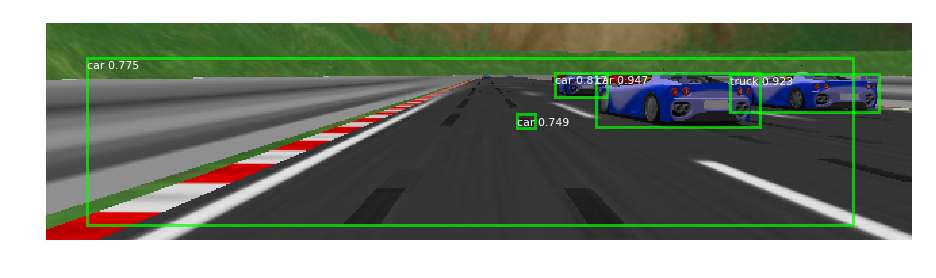

Processing 1 images
image                    shape: (160, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detections (1, 100, 6)
features:  (1, 4, 1024)


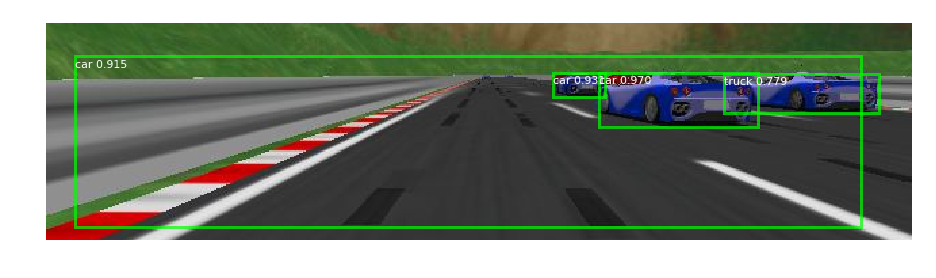

In [16]:
saver = False
display = True
write_file = False   
'''for saving observations of each video'''
all_observations = {}

'''for display'''
if display:
    colours = np.random.rand(32, 3)*255  # used only for display
    plt.ion()
    fig = plt.figure()

'''write results'''
frame = 0

'''for saving observations of each car'''
observations = {}
all_sbb_images = sorted(glob.glob(SBB_IMG_DIR + '*'))
all_raw_images = sorted(glob.glob(RAW_IMG_DIR + '*'))
all_raw_images = all_raw_images[:-30]

for i, sbb_image_file in enumerate(all_sbb_images):
    if i < 5342:
        continue
    
    raw_image_file = all_raw_images[i]
    sbb_img = cv2.imread(sbb_image_file)
    raw_img = cv2.imread(raw_image_file)
    
    raw_detection_output = RAW_OUT_DIR + raw_image_file[-18:-4] + '.txt'
    sbb_detection_output = SBB_OUT_DIR + raw_image_file[-18:-4] + '.txt'
    
#     try:
#         os.stat(raw_detection_output)
#         print(raw_image_file[-18:-4] + ' has already been processed!')
#         continue
#     except:
#         aa = 1 
    
    if sbb_img is None or raw_img is None:
        break

    sbb_img = cv2.cvtColor(sbb_img, cv2.COLOR_RGB2BGR)
    sbb_img = sbb_img[200:360,:,:]
    
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
    raw_img = raw_img[200:360,:,:]
    
    W = raw_img.shape[1]
    H = raw_img.shape[0]
    
    # detection on raw image and save
    mrcnn_detections = model.detect([raw_img], verbose=1)[0]
    interesting_objects = np.where(np.logical_and(np.logical_or(mrcnn_detections['class_ids']==3,
                                                                mrcnn_detections['class_ids']==8,),
                                                  mrcnn_detections['class_ids']<num_classes))[0]

    bboxes = mrcnn_detections['rois'][interesting_objects]
    masks = mrcnn_detections['masks'][:,:,interesting_objects]
    class_ids = mrcnn_detections['class_ids'][interesting_objects]
    scores = mrcnn_detections['scores'][interesting_objects]
    
    if write_file:
        f_out = open(RAW_OUT_DIR + raw_image_file[-18:-4] + '.txt', 'w')
        for j, bbox in enumerate(bboxes):
            w = bbox[3]-bbox[1]
            h = bbox[2]-bbox[0]
            if w > 0.7 * W or w < 0.05 * W:
                continue
            f_out.write('%d,%.3f,%d,%d,%d,%d\n' % (class_ids[j], scores[j],bbox[0],bbox[1],bbox[2],bbox[3]))

        f_out.close()
    
    if display:
        masked_img = visualize.display_instances(raw_img, bboxes, masks, class_ids, class_names,
                                                 save_path=None,
                                                  scores=scores, title="",
                                                  figsize=(16, 16), ax=None,
                                                  show_mask=False, show_bbox=True,
                                                  colors=None, captions=None)

    # detection on SBB compreseed image and save
    mrcnn_detections = model.detect([sbb_img], verbose=1)[0]
    interesting_objects = np.where(np.logical_and(np.logical_or(mrcnn_detections['class_ids']==3,
                                                                mrcnn_detections['class_ids']==8,),
                                                  mrcnn_detections['class_ids']<num_classes))[0]

    bboxes = mrcnn_detections['rois'][interesting_objects]
    masks = mrcnn_detections['masks'][:,:,interesting_objects]
    class_ids = mrcnn_detections['class_ids'][interesting_objects]
    scores = mrcnn_detections['scores'][interesting_objects]
    
    if write_file:
        f_out = open(SBB_OUT_DIR + sbb_image_file[-24:-12] + '.txt', 'w')
        for j, bbox in enumerate(bboxes):
            w = bbox[3]-bbox[1]
            h = bbox[2]-bbox[0]
            if w > 0.8 * W or w < 0.05 * w:
                continue
            f_out.write('%d,%.3f,%d,%d,%d,%d\n' % (class_ids[j], scores[j],bbox[0],bbox[1],bbox[2],bbox[3]))

        f_out.close()
    if display:
        masked_img = visualize.display_instances(sbb_img, bboxes, masks, class_ids, class_names,
                                                 save_path=None,
                                                  scores=scores, title="",
                                                  figsize=(16, 16), ax=None,
                                                  show_mask=False, show_bbox=True,
                                                  colors=None, captions=None)
    
    frame += 1

    
#     plt.clf()
    break
        